Notebook to reproduce the method: generating the global AGBD dataset, including the bioclimatic predictors, training the model and predicting. Some processes are computationally demanding and can run during multiple hours. **The total estimated execution time (EET) for the entire notebook is close to 24h.** The model calibration and error estimation procedure that relies in a nested spatial cross-validation scheme is not included in this notebook. We used the OpenMOLE platform (https://openmole.org/) to perform the numerical calibration experiments using genetic algorithms that can run over multiple days in a High Performance Computing (HPC) environment using 120 computation cores in parallel. Scripts to reproduce the calibration and error estimation workflow are provided within the **./model_calibration/** directory but need the free installation of OpenMOLE (https://openmole.org/Download.html). We do not provide access to an HPC.   

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
import re

The method builds on forest inventory data compiled in the Tallo tree-size database (Jucker et al., 2019). The following cell downloads the database and saves it within the project. **EET: 1m.** 

In [2]:
from data import fetch_tree_size_data

tree_size_data_path = fetch_tree_size_data()
tree_size_df = pd.read_csv(tree_size_data_path)

Trees with outlier values for height and crown radius are discarded from the analysis. **EET: 0s.** 

In [3]:
tree_size_df = tree_size_df[
    (tree_size_df["crown_radius_outlier"]=="N") & (tree_size_df["height_outlier"]=="N")
]

The Tallo tree-size database contains data from non-exhaustive forest inventories and forest plot area is not reported. Thus, calculating Aboveground Biomass Density (AGBD) is more complex than summing the Aboveground Biomass (AGB) of every tree in a forest plot and divide by plot area. We overcome this limitation by clustering nearby trees in groups for which we will later estimate their AGB distribution and use tree density data to calculate their AGBD by sampling the AGB distribution. In the next cell we perform the clustering procedure that is based on a Hierarchical Density-Based algorithm (HDBSCAN, Scikit Learn implementation). Reducing the distance threshold parameter increases the execution time. **EET: 1h30m.** 

In [4]:
from agbdist import cluster_trees

# Clusters with less than 25 samples will be discarded as outliers. We use as rule-of-thumb that 25 samples is a minimum requirement to estimate the AGB distribution within the clusters. 
minimum_cluster_size = 25

# Clusters separated by less than 25 meters will be merged together. This ensures that in regions with a high density of trees, we obtain fewer and larger clusters instead of many smaller ones.
distance_threshold_km = 0.025

trees_clusters_df = cluster_trees(
    tree_size_df,
    minimum_cluster_size,
    distance_threshold_km, 
    "latitude", 
    "longitude"
)

# Save the clustering results.
savepath = "./data/training/processing/trees_clusters_dthreshold_{}km_mincltsize_{}_raw.csv".format(distance_threshold_km,minimum_cluster_size)

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

trees_clusters_df.to_csv(savepath, index = False)

Before continuing the procedure to obtain a global AGBD dataset we clean the clustering results by removing outliers and we reset the cluster labels so that they start at 1. This is not a requisite but will be convenient later when adding 0 AGBD instances to the training dataset. We will then associate to all the 0 AGBD instances the same cluster label set to 0. **EET: 1s.**

In [5]:
trees_clusters_df = trees_clusters_df[ trees_clusters_df["cluster"] != -1 ]
trees_clusters_df["cluster"] = trees_clusters_df["cluster"].apply(lambda c: c+1)

# Save the clean clustering results.
savepath = "./data/training/processing/trees_clusters_dthreshold_{}km_mincltsize_{}_clean.csv".format(distance_threshold_km,minimum_cluster_size)

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

trees_clusters_df.to_csv(savepath, index = False)

We will now include bioclimatic predictors by sampling their values at the location of trees. This requires first downloading raster data from the CHELSA-BIOCLIM database (https://chelsa-climate.org/bioclim/). The download might be slow depending on connection speed because rasters are global maps at resolution of 30 arc-seconds and thus weight around 1GB. We use a set of 20 bioclimatic predictors, but this can be changed by changing the download paths in _./data/bioclimatic_data/envidatS3paths.txt_. **EET: 3m.**   

In [6]:
from data import fetch_bioclimatic_data
    
bioclimatic_data_directory = fetch_bioclimatic_data()

Now the bioclimatic data can be added to the tree dataset. **EET: 5m.**

In [7]:
bioclimatic_data_files = {
    re.findall("CHELSA_(.*)_1981",fname.stem)[0] : (str(fname),"float") for fname in Path(bioclimatic_data_directory).glob('CHELSA*.tif')
}

trees_clusters_gdf = gpd.GeoDataFrame(
    trees_clusters_df, 
    geometry=gpd.points_from_xy(trees_clusters_df.longitude, trees_clusters_df.latitude)
)
trees_clusters_gdf.crs = "EPSG:4326"

from geoutils import add_features

trees_clusters_bioclimatic_gdf = add_features(trees_clusters_gdf, bioclimatic_data_files)

savepath = "./data/training/processing/trees_clusters_bioclimatic_predictors.csv"

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

trees_clusters_bioclimatic_gdf.to_csv(savepath,index=False)

We now calculate the AGB of every tree in each cluster using _allodb_ (Gonzalez-Akre et al., 2023) and _BIOMASS_ (Rejou-Mechain et al., 2019) R packages, for extra-tropical and tropical trees respectively. The following cell embeds an R session and requires the installation of the abovementioned packages which might take a few minutes. **EET: 5m.** 

In [9]:
import rpy2.robjects as robjects

r = robjects.r

r('remotes::install_github(\'ropensci/allodb\')')
r('remotes::install_github(\'umr-amap/BIOMASS\')')

R[write to console]: Skipping install of 'allodb' from a github remote, the SHA1 (4207f861) has not changed since last install.
  Use `force = TRUE` to force installation

R[write to console]: Skipping install of 'BIOMASS' from a github remote, the SHA1 (f1305239) has not changed since last install.
  Use `force = TRUE` to force installation



'BIOMASS'


The following cell executes an R script containing the R function _agb_calculation_ and make the function callable from this Python notebook. Details of the code used for AGB calculation can be found in the R script: _./R/AGB_calculation.R_. The tree size pandas dataframe is transformed to an R dataframe and passed to the function. In turn, the function returns an R dataframe that is again transformed to a pandas dataframe to continue data processing in this Python notebook. **EET: 1h30m.**

In [10]:
# Executing the AGB_calculation script to instantiate the agb_calculation function and making it callable from this Python notebook
r.source('./R/AGB_calculation.R')
agb_calculation = robjects.globalenv['agb_calculation']

from rpy2.robjects import pandas2ri

# Transforming the pandas dataframe to an R dataframe so that it can be passed to the R session
with (robjects.default_converter + pandas2ri.converter).context():
  trees_clusters_r = robjects.conversion.get_conversion().py2rpy(trees_clusters_df[(trees_clusters_df.cluster>0) & (trees_clusters_df.cluster<trees_clusters_df.cluster.max()+1)])

# Calling the AGB calculation function in the R session
trees_clusters_agb_r = agb_calculation(trees_clusters_r,"latitude","longitude")

# Transforming the result from the AGB calculation stored in an R dataframe to a pandas dataframe
with (robjects.default_converter + pandas2ri.converter).context():
  trees_clusters_agb_df = robjects.conversion.get_conversion().rpy2py(trees_clusters_agb_r)

savepath = "./data/training/processing/trees_clusters_agb.csv"

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

trees_clusters_agb_df.to_csv(savepath,index=False)

R[write to console]: code for methods in class “Rcpp_SpatCategories” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_SpatCategories” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_SpatDataFrame” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_SpatDataFrame” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_SpatExtent” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_SpatExtent” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[

  |======================================================================| 100%


R[write to console]: Source iplant_tnrs:397398, NA:60391

R[write to console]: Corrections SpNotFound:395640, NoMatch(low_score):1535, NA:60391, FALSE:223

R[write to console]: The reference dataset contains 16467 wood density values

R[write to console]: Your taxonomic table contains 5070 taxa



We can now scale-up from the trees' AGB to clusters' AGBD. First step is gathering tree-density data (Crowther et al., 2015) that will be used to sample the AGB distributions in every cluster. This represents a download of close to 1GB of data. **EET: 3m.**

In [11]:
from data import fetch_tree_density_data

tree_density_fname = fetch_tree_density_data()

Tree density data is added to the tree dataset in the following cell. This is done by sampling a tree density map at the trees' location. **EET: 15s**.

In [12]:
trees_clusters_agb_gdf = gpd.GeoDataFrame(
    trees_clusters_agb_df, 
    geometry=gpd.points_from_xy(trees_clusters_agb_df.longitude, trees_clusters_agb_df.latitude)
)
trees_clusters_agb_gdf.crs = "EPSG:4326"

from geoutils import add_feature

trees_clusters_agb_treedensity_df  = add_feature(trees_clusters_agb_gdf, "td", tree_density_fname, "float")

savepath = "./data/training/processing/trees_clusters_agb_treedensity.csv"

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

trees_clusters_agb_treedensity_df.to_csv(savepath, index=False)

Trees' AGB was calculated both with extratropical and tropical allometries regardless of the tree location. In the next cell a final AGB value in kilograms is associated to each tree depending on their latitude. We considered as extratropical any tree above 35º of latitude North and South. For trees in the subtropical region, roughly within 23º and 35º, we followed a simple rule of thumb anc estimated the trees' AGB as the mean of tropical and extratropical estimates. **EET: 0s.**

In [1]:
import numpy as np
import pandas as pd

trees_clusters_agb_treedensity_df = pd.read_csv("./data/training/processing/trees_clusters_agb_treedensity.csv")

extra_tropical_lat = 35
subtropical_lat = 23.43619

trees_clusters_agb_treedensity_df["agb_kg"] = np.where(
    np.abs(trees_clusters_agb_treedensity_df.latitude) >= extra_tropical_lat, trees_clusters_agb_treedensity_df.agb_extra_tropical, 0.5*(trees_clusters_agb_treedensity_df.agb_extra_tropical + trees_clusters_agb_treedensity_df.agb_tropical)
)
trees_clusters_agb_treedensity_df["agb_kg"] = np.where(
    np.abs(trees_clusters_agb_treedensity_df.latitude) < subtropical_lat, trees_clusters_agb_treedensity_df.agb_tropical, trees_clusters_agb_treedensity_df.agb_kg
)

At this point the dataset includes both AGB estimations for every tree and tree density estimations at the location of every tree. This information is enough to elaborate estimates of AGBD in every cluster of trees. The estimation is done in following three steps:

(1) Empirically estimating the AGB distribution in each cluster using a kernel density estimation (KDE) algorithm for which the bandwidth parameter is calibrated for each cluster using a nested cross-validation scheme.

(2) For each cluster, sampling the obtained AGB distribution a number of times equal to the average tree-density in the cluster. The sum of all the samples is a measure of the total biomass in one unit area (unit depedns on tree-density data used) and thus a measure of AGBD.

(3) Replicate step (2) N times to increase robustness of AGBD estimation.

The results from the process are stored in a pandas DataFrame contaiinng information on the mean, median and standard deviation of AGBD estimations in every cluster. AGBD values are in kg/km2. This is saved to a CSV file. **EET: 8h.**

In [2]:
from agbdist import estimate_agbd
from pathlib import Path

kde_parameters = {
    "niter" : 100,
    "bwmin" : 0.2,
    "bwmax" : 1.5,
    "kernel" : "gaussian",
    "in_splits" : 5,
    "out_splits" :10
}
n_replicas = 10 

savepath = "./data/training/processing/clusters_agbd_kgkm2_raw.csv"

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

clusters_agbd_df = estimate_agbd(trees_clusters_agb_treedensity_df,"agb_kg","td","cluster",kde_parameters,n_replicas,save_tmp=True,save_path=savepath)

/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, wh

In the following cell the AGBD dataset is further cleaned by removing AGBD values in the 99th and 1st percentiles. If there are still values larger than the largest ever-recorded AGBD values in the world, these are removed. We based this on Keith et al. (2009) where the authors state that the largest ever-recorded AGBD value is close to 3500 Mg/ha in _Eucalyptus Regnans_ forests in Southeast Australia. **EET: 0s.** 

In [3]:
from units import mg_per_ha_to_kg_per_km2, kg_per_km2_to_mg_per_ha

# The median AGBD value is kept for the rest of the analysis.
clusters_agbd_df = clusters_agbd_df.rename(columns={"med_agbd":"agbd"})

upper_out = clusters_agbd_df["agbd"].quantile(0.99)
lower_out = clusters_agbd_df["agbd"].quantile(0.01)

clusters_agbd_df = clusters_agbd_df[(clusters_agbd_df["agbd"] > lower_out) & (clusters_agbd_df["agbd"] < upper_out)]

# For the time being AGBD values in the dataset are in kg/km2
maximum_recorded_agbd = mg_per_ha_to_kg_per_km2(3500)
clusters_agbd_df = clusters_agbd_df[clusters_agbd_df["agbd"]<maximum_recorded_agbd]

# Now values are transformed to Mg/ha
clusters_agbd_df["agbd"] = clusters_agbd_df["agbd"].apply(lambda x: kg_per_km2_to_mg_per_ha(x))

savepath = "./data/training/processing/clusters_agbd_mgha_clean.csv"

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

clusters_agbd_df[["agbd","cluster"]].to_csv(savepath,index=False)

The average value of bioclimatic variables for each cluster is calculated in the next cell. The result is then merged to the AGBD dataset. Thus the average biocoimatic conditions at the location of every sampled trees in a cluster will be used as predictors for the AGBD in that cluster. **EET: 30s.**

In [9]:
from data import fetch_bioclimatic_data
import re
bioclimatic_data_directory = fetch_bioclimatic_data()
bioclimatic_data_files = {
    re.findall("CHELSA_(.*)_1981",fname.stem)[0] : (str(fname),"float") for fname in Path(bioclimatic_data_directory).glob('CHELSA*.tif')
}
predictor_columns = list(bioclimatic_data_files.keys())

trees_clusters_bioclimatic_gdf = pd.read_csv("./data/training/processing/trees_clusters_bioclimatic_predictors.csv")

from units import rescale_bioclimatic_predictors

trees_clusters_bioclimatic_gdf = rescale_bioclimatic_predictors(trees_clusters_bioclimatic_gdf, predictor_columns)

aggregation_dict = { predictor:"mean" for predictor in predictor_columns}
aggregation_dict.update({ 'latitude_cluster' : 'first', 'longitude_cluster' : 'first'})  

dataset_columns = predictor_columns + ['latitude_cluster','longitude_cluster','cluster']

clusters_bioclim_df = trees_clusters_bioclimatic_gdf[dataset_columns].groupby("cluster").agg( aggregation_dict ).reset_index()

clusters_bioclim_df = clusters_bioclim_df.rename(columns={'latitude_cluster':'lat','longitude_cluster':'lon'})

clusters_agbd_bioclim_df = pd.merge(clusters_bioclim_df,clusters_agbd_df,on="cluster")

savepath = "./data/training/processing/clusters_agbd_mgha_bioclimatic_predictors.csv"

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

clusters_agbd_bioclim_df.to_csv(savepath,index=False)

/tmp/ipykernel_2918632/4257556927.py:9: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_clusters_bioclimatic_gdf = pd.read_csv("./data/training/processing/trees_clusters_bioclimatic_predictors.csv")


In the following cells 0 AGBD instances are included in the training dataset to ensure that the model is able to identify regions where the growth of woody vegetation is not possible. 0 AGBD locations must verify two conditions: (1) to be tree-less according to the map of tree-density published by Crowther et al. (2015), (2) to present climatic conditions that fall outside of the training range (i.e. the compiled AGBD dataset as it is at this point). A map to identify potential locations is created and then a given number of instances drawn randomly and with uniform probability are sampled from these locations. 

The next cell creates and saves two maps: (2) a map depicting the number of bioclimatic predictors outside of the training range, (2) a map depicting tree absence. Maps are processed and saved in multiple windows that are used to prevent memory overflow. In case of need the number of windows can be increased to reduce RAM usage and avoid the crash of the Jupyter kernel. **EET: 15m.**

In [12]:
from geolearn import map_number_of_predictors_out_of_range
from agbdist import map_tree_absence
from geoutils import change_raster_extent
from data import fetch_tree_density_data

savedir = "./data/training/processing/0agbd_instances/"
if not Path(savedir).exists():
    Path(savedir).mkdir(parents=True)

climate_out_of_range_map = map_number_of_predictors_out_of_range(
    clusters_agbd_bioclim_df,
    window_side=5,
    predictor_dict=bioclimatic_data_files,
    dtype = np.int8,
    nodata = -1,
    savedir = savedir
)

# Adjust the extent of the tree density raster so that it matches the extent of bioclimatic rasters. This simplifies the data processing in NumPy arrays as all have the same shape.
savepath = "./data/tree_density/tree_density_adjusted_extent.tif"
if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir(parents=True)

tree_density_fname = fetch_tree_density_data()

new_fname = change_raster_extent(list(bioclimatic_data_files.values())[0][0], tree_density_fname,savepath)

tree_absence_map = map_tree_absence(
    new_fname,
    window_side=5,
    nodata=9999,
    savedir=savedir
)

The next cell creates the maps depicting potential locations to sample 0AGBD points, based on the maps generated in the previous cell. **EET: 20s.**

In [13]:
from natsort import natsorted

# This sorts the paths by file name to ensure that windows are processed in the same order. Latitude and longitude information are the suffixes of filenames and thus force the ordering.
sorted_climate_files = natsorted(climate_out_of_range_map,key=str)
sorted_tree_files = natsorted(tree_absence_map,key=str)

from prediction import map_0_agbd

savedir = "./data/training/processing/0agbd_instances/0agbd/"
if not Path(savedir).exists():
    Path(savedir).mkdir(parents=True)

agbd_0_maps = []
for tree_map, climate_map in list(zip(sorted_tree_files,sorted_climate_files)):
    agbd_0_map = map_0_agbd( tree_map, climate_map, np.uint8, 255, savedir)
    agbd_0_maps.append(agbd_0_map)

/tmp/ipykernel_2918632/1175762722.py:15: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  agbd_0_map = map_0_agbd( tree_map, climate_map, np.uint8, 255, savedir)
/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_2918632/1175762722.py:15: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  agbd_0_map = map_0_agbd( tree_map, climate_map, np.uint8, 255, savedir)
/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecat

0 AGBD instances can now be sampled from the previously generated maps. The number of instances is chosen accroding to the fraction of 0 tree density cells in the tree density map published by Crowther et al. (2015), which is close to 0.39. Bioclimatic conditions at the locatino of 0 AGBD instances area also gathered at this point. The cluster label 0 is associated to every 0 AGBD instance. **EET: 1m.**

In [14]:
from prediction import add_0_agbd_instances

# TODO: CALCULATE FRACTION OF NULL TREE DENSITY INSTEAD OF HAVING IT HARDCODED
# Adjust coefficient in funciton of fraction of 0AGBD points in the world estimated to 39 percent in the map from Crowther et al. (2015). In the final dataset 0 AGBD instances will represent 39% of the total number of instances.
coeff = 0.39/0.61 
n_instances = int(len(clusters_agbd_bioclim_df)*coeff)

agbd_bioclim_training_dataset_df = add_0_agbd_instances(clusters_agbd_bioclim_df, agbd_0_maps, n_instances, bioclimatic_data_files)

savepath = "./data/training/agbd_climate_training_dataset.csv"
if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir()
agbd_bioclim_training_dataset_df.to_csv(savepath,index=False)

The global AGBD training dataset is finally ready. Spatial cross-validation folds will be created for model calibration and error estimation purposes. Spatial folds prevent data leakage from training to testing datasets that could be originated by spatial autocorrelatino in the data. Spatial folds are created with a clustering algorihtm using a distance threshold equal to the autocorrelation distance of the data. Thus the first step is to estiamte the data's autocorrelation distance by plotting its variogram. The variogram's Y-axis corresponds to the data semivariance and the X-axis to the spatial distance in kilometers, or lag. The lag at which the semivariance curve saturates is a measure of the data's autocorrelation distance. In the present case, it is reasonable to set the autocorrelation distance to 1000km. The variogram plotted here appears in Supplementary Material (SM) 1. **EET:2m.**

/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


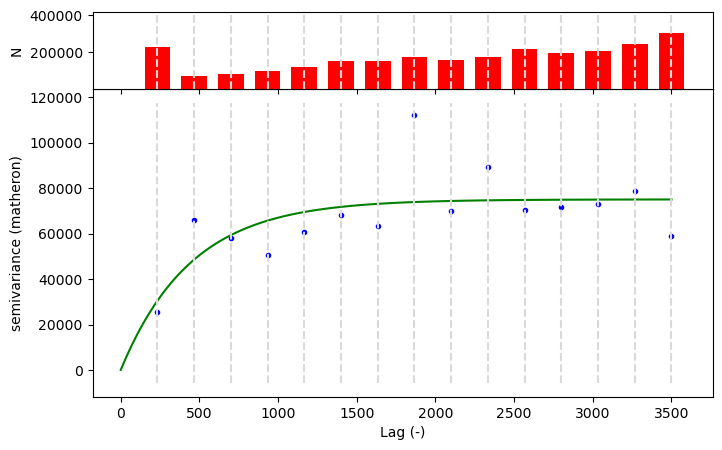

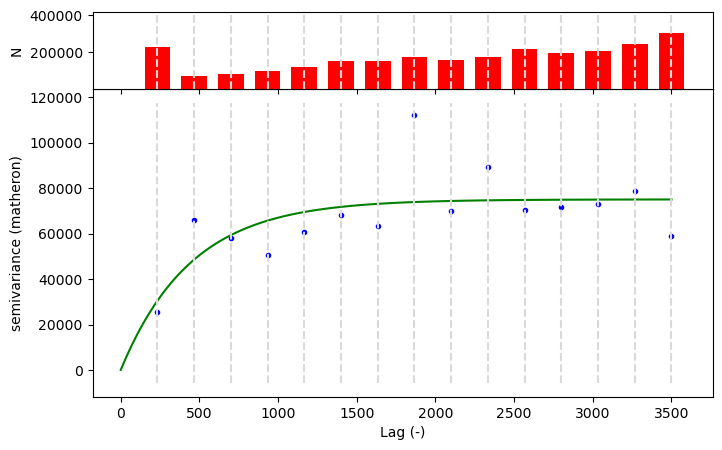

In [15]:
import skgstat as skg
from geoutils import haversine_distance_km_from_lat_lon

coords = agbd_bioclim_training_dataset_df[["lat","lon"]]

coords = coords.to_numpy()
values = agbd_bioclim_training_dataset_df["agbd"].to_numpy()

variogram = skg.Variogram(coords, values, dist_func=haversine_distance_km_from_lat_lon, n_lags=15, maxlag=3500, model = "exponential")

variogram.plot()

The next cell executes a hierarchical clustering algorithm with a distance threshold set to the autocorrelation distance to split AGBD instances in spatial cross-validation folds. A column storing the fold label is added to the dataset. **EET: 1m.**

In [16]:
from geolearn import add_spatial_cv_folds

# Autocorrelation distance.
distance = 1000 #km

agbd_bioclim_training_dataset_df = add_spatial_cv_folds(agbd_bioclim_training_dataset_df,distance,"lat","lon")

savepath = "./data/training/agbd_climate_training_dataset_spatialkfolds_{}km.csv".format(distance)

if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir()
    
agbd_bioclim_training_dataset_df.to_csv(savepath,index=False)

Use optimal hyperparameters and set of predictors found during calibration to train the final potential AGBD prediction model. **EET: 3s.**

In [22]:
from training import training_pipeline
import pickle 
import pandas as pd
import re
from pathlib import Path

agbd_bioclim_training_dataset_df = pd.read_csv("./data/training/agbd_climate_training_dataset_spatialkfolds_1000km.csv")

parameters = pd.read_csv("./data/calibration/model_calibration_results/population54000.csv")

parameters = parameters[ parameters["evolution$samples"]==100]

# Dictionary translating between hyperparameter names needed for XGBoost library and the ones used during calibration.
hyper_parameter_names = {
    "n_estimators" : "n_estimators",
    "learning_rate" : "e",
    "max_depth" : "md", 
    "min_child_weight" : "mcw",
    "subsample" : "subsample",
    "min_split_loss" : "g",
    "max_delta_step" : "mds"
}

# This operation is only used to generate a list of predictor names.
bioclimatic_data_directory = "./data/bioclimatic_data/"
bioclimatic_data_files = {
    re.findall("CHELSA_(.*)_1981",fname.stem)[0] : (str(fname),"float") for fname in Path(bioclimatic_data_directory).glob('CHELSA*.tif')
}
predictor_names = list(bioclimatic_data_files.keys())

# Instantiate training pipeline.
agbd_estimator = training_pipeline(parameters,hyper_parameter_names,predictor_names, logarithmize_agbd=True)

# Train the model.
model = agbd_estimator.fit(agbd_bioclim_training_dataset_df, agbd_bioclim_training_dataset_df["agbd"])

model_savepath = "./model/potential_agbd_Mgha_climate_envelope.pkl"

if not Path(model_savepath).parents[0].exists():
    Path(model_savepath).parents[0].mkdir()
pickle.dump(model, open(model_savepath, 'wb'))

/home/dibepa/git/agbd.clim/training.py:95: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_estimators=int(parameters[hp_names["n_estimators"]]),
/home/dibepa/git/agbd.clim/training.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  learning_rate=float(parameters[hp_names["learning_rate"]]),
/home/dibepa/git/agbd.clim/training.py:97: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_depth = int(parameters[hp_names["max_depth"]]),
/home/dibepa/git/agbd.clim/training.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_child_weight=float(parameters[hp_names["min_child_weight"]]),
/home/dibepa/git/agbd.

The following cell creates the prediction dataset in CSV format to facilitate the import as pandas DataFrames for prediction with the trained model. The process involves sampling the values of each predictor in land territories and storing them in the same file. The process is carried over raster windows to avoid memory overflow. **EET: 4h30m**

In [ ]:
from prediction import create_prediction_dataset
from pathlib import Path
import fiona

# TODO: put this in data directory!!
with fiona.open("/home/dibepa/Documents/continents_shapefile/Continents.shp", "r") as shapefile:
    land_polygons = [feature["geometry"] for feature in shapefile if feature.properties["CONTINENT"]!="Antarctica"]

savedir = "./data/prediction/prediction_dataset/"
if not Path(savedir).exists():
    Path(savedir).mkdir(parents=True)

prediction_datasets = create_prediction_dataset(bioclimatic_data_files,land_polygons,20,savedir)

The following cell executes the prediction of potential AGBD using the trained model. Prediction results are saved in CSV files and each file corresponds to a world tile. The production of georeferenced data in TIFF format is carried over in the next cell. **EET: 20m.**

In [24]:
from prediction import predict
from pathlib import Path

prediction_datasets = [str(file) for file in Path("./data/prediction/prediction_dataset/").glob('*')]

savedir = "./data/prediction/prediction_results/" 
if not Path(savedir).exists():
    Path(savedir).mkdir(parents=True)

prediction_results = predict(model, prediction_datasets, savedir)

All the prediction results are now used to produce the maps of potential AGBD for each processing tile. Transform information of a reference raster (one of the predictors) is needed for georeferenciation. **EET: 1h.**

In [25]:
from prediction import create_potential_agbd_maps
from pathlib import Path
import re

bioclimatic_data_directory = "./data/bioclimatic_data/"
bioclimatic_data_files = {
    re.findall("CHELSA_(.*)_1981",fname.stem)[0] : (str(fname),"float") for fname in Path(bioclimatic_data_directory).glob('CHELSA*.tif')
}

reference_rasterfile = list(bioclimatic_data_files.values())[0][0]

savedir = "./data/prediction/potential_AGBD_maps/"
if not Path(savedir).exists():
    Path(savedir).mkdir(parents=True)

prediction_results = [str(file) for file in Path("./data/prediction/prediction_results/").glob('*')]

map_paths = create_potential_agbd_maps(prediction_results, reference_rasterfile, savedir)

Merge all windowed prediction in a single map. **Caution: this process is very demanding in terms of memory and might crash the Jupyter kernel. Minimum RAM needed : 30GB. Recommended: 64GB** If needed, restart the Jupyter kernel to liberate memory before executing the cell. If the kernel keeps crashing, you may try: (1) close all other runnning processes in your machine (e.g. internet browser, IDE), (2) execute the script **./merge_agbd_tiles.py** from a terminal. The latter script performs the same operation but with code that does not depend on other modules and that is not executed within a Jupyter Notebook, in consequence memory usage is reduced to some extent.  

In [ ]:
from geoutils import merge_rasters
from pathlib import Path

map_paths = [str(file) for file in Path("./data/prediction/potential_AGBD_maps/").glob('*')]

savepath = './data/prediction/potential_AGBD_Mgha_1km2_present_climatic_conditions.tif' 
if not Path(savepath).parents[0].exists():
    Path(savepath).parents[0].mkdir()

global_agbd_map = merge_rasters(map_paths,savepath)

: 